In [51]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, UpSampling2D, Conv2DTranspose

In [52]:
def load_images_from_directory(directory, size=(64, 64)):
    images = []
    for filename in os.listdir(directory):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img_path = os.path.join(directory, filename)
            img = Image.open(img_path)
            img = img.resize(size)
            img = np.array(img) / 255.0
            images.append(img)
    return np.array(images)

In [53]:
train_noisy_dir = 'C:\\Users\\hp\\Desktop\\IMAGE DENOISING PROJECT\\Dataset\\Train\\Noisy'
train_clean_dir = 'C:\\Users\\hp\\Desktop\\IMAGE DENOISING PROJECT\\Dataset\\Train\\Clean'
test_noisy_dir = 'C:\\Users\\hp\\Desktop\\IMAGE DENOISING PROJECT\\Dataset\\Test\\Noisy'
test_clean_dir = 'C:\\Users\\hp\\Desktop\\IMAGE DENOISING PROJECT\\Dataset\\Test\\Clean'

In [54]:
train_noisy_images = load_images_from_directory(train_noisy_dir)
train_clean_images = load_images_from_directory(train_clean_dir)
test_noisy_images = load_images_from_directory(test_noisy_dir)
test_clean_images = load_images_from_directory(test_clean_dir)

print("Train Noisy Images Shape: ", train_noisy_images.shape)
print("Train Clean Images Shape: ", train_clean_images.shape)
print("Test Noisy Images Shape: ", test_noisy_images.shape)
print("Test Clean Images Shape: ", test_clean_images.shape)

train_noisy_images = train_noisy_images.astype('float64')
train_clean_images = train_clean_images.astype('float64')
test_noisy_images = test_noisy_images.astype('float64')
test_clean_images = test_clean_images.astype('float64')

Train Noisy Images Shape:  (437, 64, 64, 3)
Train Clean Images Shape:  (437, 64, 64, 3)
Test Noisy Images Shape:  (48, 64, 64, 3)
Test Clean Images Shape:  (48, 64, 64, 3)


In [55]:
def residual_block_lab(input_tensor, filters):
    x = Conv2D(filters, 3, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)

    shortcut = Conv2D(filters, 1, padding='same')(input_tensor)
    shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

In [56]:
def unet_model_with_residuals(input_size=(64, 64, 3)):
    inputs = Input(input_size)
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = residual_block_lab(conv1, 32)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, activation='relu', padding='same')(pool1)
    conv2 = residual_block_lab(conv2, 64)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, 3, activation='relu', padding='same')(pool2)
    conv3 = residual_block_lab(conv3, 128)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, 3, activation='relu', padding='same')(pool3)
    conv4 = residual_block_lab(conv4, 256)

    up5 = concatenate([UpSampling2D(size=(2, 2))(conv4), conv3], axis=-1)
    conv5 = Conv2D(128, 3, activation='relu', padding='same')(up5)
    conv5 = residual_block_lab(conv5, 128)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv2], axis=-1)
    conv6 = Conv2D(64, 3, activation='relu', padding='same')(up6)
    conv6 = residual_block_lab(conv6, 64)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv1], axis=-1)
    conv7 = Conv2D(32, 3, activation='relu', padding='same')(up7)
    conv7 = residual_block_lab(conv7, 32)

    conv8 = Conv2D(3, 1, activation='sigmoid')(conv7)  # Output layer with 3 channels

    model = Model(inputs=[inputs], outputs=[conv8])

    return model


In [57]:
model = unet_model_with_residuals((64, 64, 3))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mean_squared_error')

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=25, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.01, patience=15, min_lr=0.00000001)
]

history = model.fit(train_noisy_images, train_clean_images, epochs=50, batch_size=8, validation_data=(test_noisy_images, test_clean_images), callbacks=callbacks)

denoised_images = model.predict(test_noisy_images)

Epoch 1/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 78s 413ms/step - loss: 0.0368 - val_loss: 0.1933 - learning_rate: 0.0100
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 20s 369ms/step - loss: 0.0211 - val_loss: 0.0556 - learning_rate: 0.0100
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 20s 365ms/step - loss: 0.0183 - val_loss: 0.0355 - learning_rate: 0.0100
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 376ms/step - loss: 0.0181 - val_loss: 0.0288 - learning_rate: 0.0100
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 389ms/step - loss: 0.0166 - val_loss: 0.0449 - learning_rate: 0.0100
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - loss: 0.0173 - val_loss: 0.0239 - learning_rate: 0.0100
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 379ms/step - loss: 0.0147 - val_loss: 0.0246 - learning_rate: 0.0100
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 382ms/step - loss: 0.0157 - val_loss: 0.1594 - learning_rate: 0.0100
Epoch 9/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 382ms/step - loss: 0.0144 - val_loss: 0.0278 - learning_rate: 0.0100
E

In [13]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model

def residual_block_lab(input_tensor, filters):
    x = Conv2D(filters, 3, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)

    shortcut = Conv2D(filters, 1, padding='same')(input_tensor)
    shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def unet_model_with_residuals(input_size=(32, 32, 3)):
    inputs = Input(input_size)
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = residual_block_lab(conv1, 32)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, activation='relu', padding='same')(pool1)
    conv2 = residual_block_lab(conv2, 64)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, 3, activation='relu', padding='same')(pool2)
    conv3 = residual_block_lab(conv3, 128)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, 3, activation='relu', padding='same')(pool3)
    conv4 = residual_block_lab(conv4, 256)

    up5 = concatenate([UpSampling2D(size=(2, 2))(conv4), conv3], axis=-1)
    conv5 = Conv2D(128, 3, activation='relu', padding='same')(up5)
    conv5 = residual_block_lab(conv5, 128)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv2], axis=-1)
    conv6 = Conv2D(64, 3, activation='relu', padding='same')(up6)
    conv6 = residual_block_lab(conv6, 64)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv1], axis=-1)
    conv7 = Conv2D(32, 3, activation='relu', padding='same')(up7)
    conv7 = residual_block_lab(conv7, 32)

    conv8 = Conv2D(3, 1, activation='sigmoid')(conv7)  # Output layer with 3 channels

    model = Model(inputs=[inputs], outputs=[conv8])

    return model

# Compile the model
model = unet_model_with_residuals((32, 32, 3))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mean_squared_error')

# Example usage
# Assuming you have your training and testing datasets prepared
# train_noisy_images, train_clean_images, test_noisy_images, test_clean_images

# Train the model with early stopping and learning rate scheduler
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=30, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=20, min_lr=0.000001)
]

history = model.fit(train_noisy_images, train_clean_images, epochs=50, batch_size=32, validation_data=(test_noisy_images, test_clean_images), callbacks=callbacks)

# Predict on test data
denoised_images = model.predict(test_noisy_images)


Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 35s 426ms/step - loss: 0.0502 - val_loss: 0.2971 - learning_rate: 0.0100
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 276ms/step - loss: 0.0233 - val_loss: 0.2767 - learning_rate: 0.0100
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 278ms/step - loss: 0.0209 - val_loss: 0.2756 - learning_rate: 0.0100
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 287ms/step - loss: 0.0188 - val_loss: 0.2326 - learning_rate: 0.0100
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 290ms/step - loss: 0.0164 - val_loss: 0.2215 - learning_rate: 0.0100
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 293ms/step - loss: 0.0155 - val_loss: 0.1035 - learning_rate: 0.0100
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 285ms/step - loss: 0.0138 - val_loss: 0.1863 - learning_rate: 0.0100
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 284ms/step - loss: 0.0147 - val_loss: 0.1610 - learning_rate: 0.0100
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 287ms/step - loss: 0.0128 - val_loss: 0.2123 - learning_rate: 0.0100
Epoch 10/

In [60]:
def calculate_psnr(original, denoised):
    mse = np.mean((original - denoised) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 1.0
    psnr = 20 * np.log10(PIXEL_MAX / np.sqrt(mse))
    return psnr

# Calculate PSNR, MSE, and MAE
psnr_scores = [calculate_psnr(test_clean_images[i], denoised_images[i]) for i in range(len(test_clean_images))]
avg_psnr = np.mean(psnr_scores)
mse_score = np.mean((test_clean_images - denoised_images) ** 2)
mae_score = np.mean(np.abs(test_clean_images - denoised_images))

print(f'Average PSNR: {avg_psnr}')
print(f'MSE: {mse_score}')
print(f'MAE: {mae_score}')

Average PSNR: 20.73977539831792
MSE: 0.010839504280585336
MAE: 0.08705125193538381


In [15]:
import tensorflow as tf
import numpy as np

class PSNRCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_data):
        super(PSNRCallback, self).__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        noisy_images = self.validation_data[0]
        clean_images = self.validation_data[1]
        denoised_images = self.model.predict(noisy_images)
        psnrs = []
        for i in range(len(clean_images)):
            psnr = calculate_psnr(clean_images[i], denoised_images[i])
            psnrs.append(psnr)
        
        avg_psnr = np.mean(psnrs)
        print(f' - val_psnr: {avg_psnr:.2f}')


In [37]:

model = unet_model_with_residuals((32, 32, 3))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mean_squared_error')

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=30, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=20, min_lr=0.000001),
    PSNRCallback(validation_data=(test_noisy_images, test_clean_images))
]

history = model.fit(train_noisy_images, train_clean_images, epochs=100, batch_size=8, validation_data=(test_noisy_images, test_clean_images), callbacks=callbacks)


Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step/step - loss: 0.03
 - val_psnr: 6.83
55/55 ━━━━━━━━━━━━━━━━━━━━ 41s 223ms/step - loss: 0.0386 - val_loss: 0.2628 - learning_rate: 0.0100
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step ep - loss: 0.0
 - val_psnr: 13.68
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - loss: 0.0226 - val_loss: 0.0581 - learning_rate: 0.0100
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step ep - loss: 0.0
 - val_psnr: 13.40
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - loss: 0.0200 - val_loss: 0.0676 - learning_rate: 0.0100
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/stepep - loss: 0.
 - val_psnr: 12.97
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - loss: 0.0180 - val_loss: 0.0834 - learning_rate: 0.0100
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step ep - loss: 0.0
 - val_psnr: 16.28
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - loss: 0.0162 - val_loss: 0.0305 - learning_rate: 0.0100
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step ep - loss: 0.0
 - val_psnr: 17.74
5

In [38]:
denoised_images = model.predict(test_noisy_images)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


In [39]:
def calculate_psnr(original, denoised):
    mse = np.mean((original - denoised) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 1.0
    psnr = 20 * np.log10(PIXEL_MAX / np.sqrt(mse))
    return psnr

# Calculate PSNR, MSE, and MAE
psnr_scores = [calculate_psnr(test_clean_images[i], denoised_images[i]) for i in range(len(test_clean_images))]
avg_psnr = np.mean(psnr_scores)
mse_score = np.mean((test_clean_images - denoised_images) ** 2)
mae_score = np.mean(np.abs(test_clean_images - denoised_images))

print(f'Average PSNR: {avg_psnr}')
print(f'MSE: {mse_score}')
print(f'MAE: {mae_score}')

Average PSNR: 21.476344380257814
MSE: 0.011056872089780232
MAE: 0.08457357411466772


In [32]:

model = unet_model_with_residuals((32, 32, 3))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mean_squared_error')

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=30, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=20, min_lr=0.000001),
    PSNRCallback(validation_data=(test_noisy_images, test_clean_images))
]

history = model.fit(train_noisy_images, train_clean_images, epochs=100, batch_size=8, validation_data=(test_noisy_images, test_clean_images), callbacks=callbacks)


Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step/step - loss: 0.04
 - val_psnr: 5.47
28/28 ━━━━━━━━━━━━━━━━━━━━ 47s 443ms/step - loss: 0.0435 - val_loss: 0.3059 - learning_rate: 0.0100
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step ep - loss: 0.0
 - val_psnr: 5.54
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 220ms/step - loss: 0.0231 - val_loss: 0.2885 - learning_rate: 0.0100
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/stepep - loss: 0.
 - val_psnr: 10.88
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 209ms/step - loss: 0.0194 - val_loss: 0.1069 - learning_rate: 0.0100
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/stepep - loss: 0.
 - val_psnr: 11.65
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 215ms/step - loss: 0.0180 - val_loss: 0.1067 - learning_rate: 0.0100
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step ep - loss: 0.0
 - val_psnr: 14.61
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 209ms/step - loss: 0.0163 - val_loss: 0.0412 - learning_rate: 0.0100
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step ep - loss: 0.0
 - val_psnr: 13.45
28/

In [33]:
denoised_images = model.predict(test_noisy_images)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


In [34]:
def calculate_psnr(original, denoised):
    mse = np.mean((original - denoised) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 1.0
    psnr = 20 * np.log10(PIXEL_MAX / np.sqrt(mse))
    return psnr

# Calculate PSNR, MSE, and MAE
psnr_scores = [calculate_psnr(test_clean_images[i], denoised_images[i]) for i in range(len(test_clean_images))]
avg_psnr = np.mean(psnr_scores)
mse_score = np.mean((test_clean_images - denoised_images) ** 2)
mae_score = np.mean(np.abs(test_clean_images - denoised_images))

print(f'Average PSNR: {avg_psnr}')
print(f'MSE: {mse_score}')
print(f'MAE: {mae_score}')

Average PSNR: 21.24532291599769
MSE: 0.012458131677450766
MAE: 0.08936382283451476


In [35]:
model = unet_model_with_residuals((32, 32, 3))
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), loss='mean_squared_error')

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=30, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=20, min_lr=0.000001)   
]
history = model.fit(train_noisy_images, train_clean_images, epochs=50, batch_size=16, validation_data=(test_noisy_images, test_clean_images), callbacks=callbacks)
denoised_images = model.predict(test_noisy_images)

Epoch 1/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step/step - loss: 0.04
 - val_psnr: 13.79
28/28 ━━━━━━━━━━━━━━━━━━━━ 29s 356ms/step - loss: 0.0418 - val_loss: 0.0473 - learning_rate: 0.0010
Epoch 2/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step ep - loss: 0.0
 - val_psnr: 13.39
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 195ms/step - loss: 0.0221 - val_loss: 0.0558 - learning_rate: 0.0010
Epoch 3/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step ep - loss: 0.0
 - val_psnr: 13.70
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 188ms/step - loss: 0.0178 - val_loss: 0.0490 - learning_rate: 0.0010
Epoch 4/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step ep - loss: 0.0
 - val_psnr: 13.23
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 187ms/step - loss: 0.0167 - val_loss: 0.0590 - learning_rate: 0.0010
Epoch 5/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step ep - loss: 0.0
 - val_psnr: 13.83
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 199ms/step - loss: 0.0134 - val_loss: 0.0493 - learning_rate: 0.0010
Epoch 6/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step ep - loss: 0.0
 - val_psnr: 13.92

In [36]:
def calculate_psnr(original, denoised):
    mse = np.mean((original - denoised) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 1.0
    psnr = 20 * np.log10(PIXEL_MAX / np.sqrt(mse))
    return psnr

# Calculate PSNR, MSE, and MAE
psnr_scores = [calculate_psnr(test_clean_images[i], denoised_images[i]) for i in range(len(test_clean_images))]
avg_psnr = np.mean(psnr_scores)
mse_score = np.mean((test_clean_images - denoised_images) ** 2)
mae_score = np.mean(np.abs(test_clean_images - denoised_images))

print(f'Average PSNR: {avg_psnr}')
print(f'MSE: {mse_score}')
print(f'MAE: {mae_score}')

Average PSNR: 20.975322340443455
MSE: 0.011137212702126342
MAE: 0.0863155349612989


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Activation, Multiply, Add, BatchNormalization
from tensorflow.keras.models import Model

def cgnet_model(input_size=(32, 32, 3), filters=64):
    inputs = Input(shape=input_size)
    
    x = Conv2D(filters, (3, 3), padding='same', kernel_initializer='he_normal')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    for _ in range(4):
        residual = x
        
        x = Conv2D(filters, (3, 3), padding='same', kernel_initializer='he_normal')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        
        x = Conv2D(filters, (3, 3), padding='same', kernel_initializer='he_normal')(x)
        x = BatchNormalization()(x)
        
        x = Activation('sigmoid')(x)
        x = Multiply()([x, residual])
        
        x = Add()([x, residual])
        x = Activation('relu')(x)
    
    denoised = Conv2D(input_size[-1], (3, 3), padding='same', kernel_initializer='he_normal')(x)
    
    model = Model(inputs=inputs, outputs=denoised, name='cgnet')
    return model

model = cgnet_model(input_size=(32, 32, 3))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=30, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=20, min_lr=0.000001),
    PSNRCallback(validation_data=(test_noisy_images, test_clean_images))
]

history = model.fit(train_noisy_images, train_clean_images, epochs=50, batch_size=32, validation_data=(test_noisy_images, test_clean_images), callbacks=callbacks)

denoised_images = model.predict(test_noisy_images)


In [49]:
def calculate_psnr(original, denoised):
    mse = np.mean((original - denoised) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 1.0
    psnr = 20 * np.log10(PIXEL_MAX / np.sqrt(mse))
    return psnr

psnr_scores = [calculate_psnr(test_clean_images[i], denoised_images[i]) for i in range(len(test_clean_images))]
avg_psnr = np.mean(psnr_scores)
mse_score = np.mean((test_clean_images - denoised_images) ** 2)
mae_score = np.mean(np.abs(test_clean_images - denoised_images))

print(f'Average PSNR: {avg_psnr}')
print(f'MSE: {mse_score}')
print(f'MAE: {mae_score}')

Average PSNR: 18.14056804395972
MSE: 0.01881349734796955
MAE: 0.11413509985672143


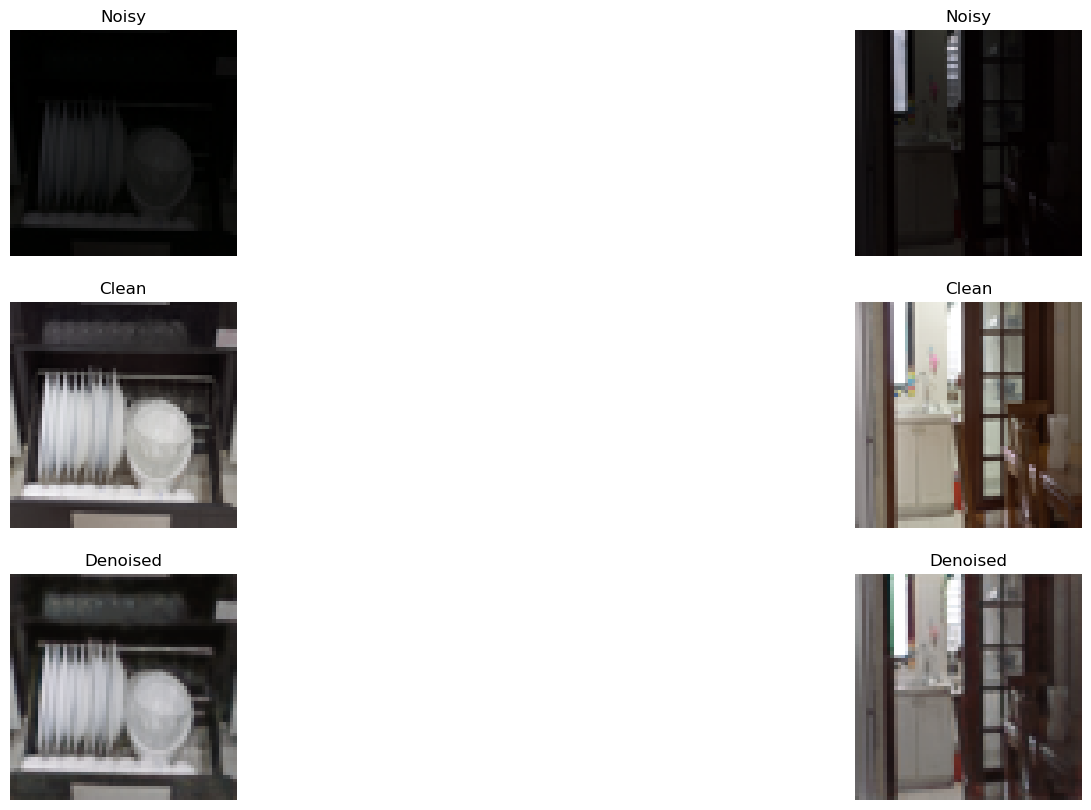

In [62]:
n = 2
plt.figure(figsize=(20, 10))
for i in range(n):
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(test_noisy_images[i])
    plt.title("Noisy")
    plt.axis("off")

    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(test_clean_images[i])
    plt.title("Clean")
    plt.axis("off")

    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(denoised_images[i])
    plt.title("Denoised")
    plt.axis("off")
plt.show()

In [63]:
from PIL import Image
import numpy as np

denoised_images_resized = []

for img_array in denoised_images:
    img = Image.fromarray((img_array * 255).astype(np.uint8))  
    img_resized = img.resize((600, 400), Image.Resampling.LANCZOS)
    denoised_images_resized.append(np.array(img_resized))

denoised_images_resized = np.array(denoised_images_resized)

In [64]:
def load_images_from_directory(directory, size=(600, 400)):
    images = []
    for filename in os.listdir(directory):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img_path = os.path.join(directory, filename)
            img = Image.open(img_path)
            img = img.resize(size)
            img = np.array(img) / 255.0
            images.append(img)
    return np.array(images)

In [65]:
test_noisy_images = load_images_from_directory(test_noisy_dir)
test_clean_images = load_images_from_directory(test_clean_dir)

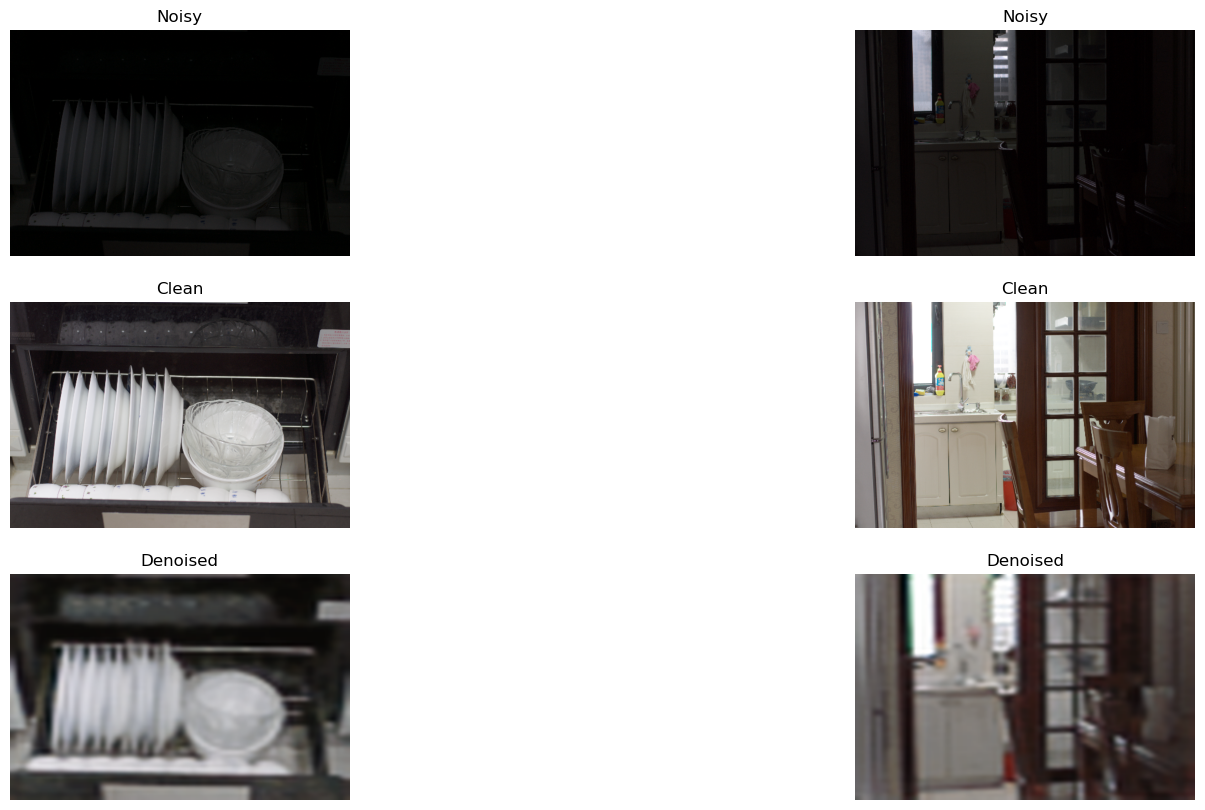

In [82]:
n = 2
plt.figure(figsize=(20, 10))
for i in range(n):
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(test_noisy_images[i])
    plt.title("Noisy")
    plt.axis("off")

    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(test_clean_images[i])
    plt.title("Clean")
    plt.axis("off")

    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(denoised_images_resized[i])
    plt.title("Denoised")
    plt.axis("off")
plt.show()